# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import time
import pickle
import numpy as np
import tensorflow as tf
import csv
import cv2
from cv2 import createCLAHE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.optimizers import Adam, SGD
from keras.layers import Input, Flatten, Dense, Conv2D, Add, Lambda, Cropping2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

DISABLE_PRINTS = False
EVALUATE_BATCH_TRAINING = True
GENERATE_AUGMENTED_DATA = False
USE_AUGMENTED = False
TRAIN_MODEL = True
GRAY_SCALE = False 
LEARNING_CURVE = False # If False trains for all the training set
beta = 1e-2

# Load pickled data
if USE_AUGMENTED:
    training_file = './traffic-signs-data/train_augmented.p'
else:
    training_file = './traffic-signs-data/train.p'

validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

train_dict = pickle.load(open(training_file, mode='rb') )
valid_dict = pickle.load(open(validation_file, mode='rb'))
test_dict  = pickle.load(open(testing_file, mode='rb'))

if USE_AUGMENTED:
    X_train, y_train = train_dict['features'], train_dict['labels']
else:
    coords_train, X_train, sizes_train, y_train = train_dict['coords'], train_dict['features'], train_dict['sizes'], train_dict['labels']

X_valid, y_valid = valid_dict['features'], valid_dict['labels']
X_test, y_test = test_dict['features'], test_dict['labels']

Using TensorFlow backend.


In [22]:
def histogram_equalization(data_set, equalize = True, gridSize = (4, 4)):
    '''
    1) computes variance of pixel values in a gray scale image
    2) equalizes the grayscale image using CLAHE for better contrast   
    
    '''
    perImage_pixel_variance = []
    hist_equ_data_set = []
    clahe = createCLAHE(tileGridSize=gridSize)
    for img in data_set:        
        
        if img.shape[-1] == 3: 
            img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)            
            y_channel = img_YCrCb[...,0]
            # Compute the variance of grayscale image b4 equalization
            perImage_pixel_variance.append(np.var(y_channel))
            if equalize:                
                y_channel = clahe.apply(y_channel)            
                img_YCrCb[..., 0] = y_channel
                img_rgb = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
                hist_equ_data_set.append(img_rgb)              
        else:
            gray_scale_img = np.copy(img)        
            # Compute the variance of grayscale image b4 equalization
            perImage_pixel_variance.append(np.var(gray_scale_img))
            if equalize:
                gray_scale_img = clahe.apply(gray_scale_img)            
                hist_equ_data_set.append(gray_scale_img)  
            
    
    if equalize:
        if data_set.shape[-1] == 3:
            return np.array(hist_equ_data_set)
        else:
            return np.expand_dims(hist_equ_data_set, axis = 3)
    else:
        return np.array(perImage_pixel_variance)
    

def get_boxed_images(data_set, coords, sizes):    
    '''
    Draw bounding boxes on images
    '''
    boxed_data = []
    for idx in range(data_set.shape[0]):
        img = data_set[idx]
        x1, y1, x2, y2 = coords[idx,:]
        x1 = round(x1*32/sizes[idx,0]).astype('int')
        x2 = round(x2*32/sizes[idx,0]).astype('int')
        y1 = round(y1*32/sizes[idx,1]).astype('int')
        x2 = round(y2*32/sizes[idx,1]).astype('int')
        bbox = [(x1, y1), (x2, y2)]
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 1)
        boxed_data.append(img)
    
    return np.array(boxed_data)


def get_cropped_images(data_set, coords, sizes):    
    '''
    Crop images using bounding boxes
    '''
    cropped_data = []
    for idx in range(data_set.shape[0]):
        img = data_set[idx]
        x1, y1, x2, y2 = coords[idx,:]
        x1 = round(x1*32/sizes[idx,0]).astype('int')
        x2 = round(x2*32/sizes[idx,0]).astype('int')
        y1 = round(y1*32/sizes[idx,1]).astype('int')
        x2 = round(y2*32/sizes[idx,1]).astype('int')
        cropped_data.append(cv2.resize(img[y1:y2+1,x1:x2+1], (32, 32)))
    
    return np.array(cropped_data)


def normalize_dataset(data_set):
    '''
    normalizes image such that for each image pixel values are between -0.5, +0.5
    '''
    normalized_data_set = []
    for s in range(data_set.shape[0]):
        img  = np.copy(data_set[s]).astype(float)
        max_pixel = np.max(img)
        min_pixel = np.min(img)
        # pixels after normalization are in range [-0.5, +0.5]
        img = (img - min_pixel)/(max_pixel-min_pixel) - 0.5
        normalized_data_set.append(img)    
    
    return np.array(normalized_data_set)
        
def gray_scale_dataset(data_set):
    if data_set.shape[-1] == 3:
        ''' converts RGB images to gray scale'''
        return np.expand_dims([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in data_set], axis = 3)
    else:
        return np.array(data_set)

def show_image(img):
    '''
    Helper function for display.
    Converts an image into uint8
    '''
    if np.min(img) < 0:
        # convert all pixels positive for display purposes
        img = img + np.absolute(np.min(img))
    img = img/np.max(img)*255
    img = img.astype('uint8')
    return img 



def list_images(images, xaxis = "", yaxis ="", cmap=None, ncols = 10, title = ''):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            yaxis (Default = " "): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 10))    
    n_images = len(images)
    nrows = np.ceil(n_images/ncols) 

    for i in range(n_images):
        plt.subplot(nrows, ncols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if images[i].shape[-1] != 3 else cmap
        plt.imshow(np.squeeze(show_image(images[i])), cmap = cmap)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.xticks([])
        plt.yticks([])    
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)    
    plt.title(title, loc = 'center', fontsize=16)        
    plt.show()        
    
    
def rotate_image(image, angle_range = (5, 15)):
    """Source:
    http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations
    /py_geometric_transformations.html
    """
    random_angle = np.random.uniform(angle_range[0], angle_range[1], size = 1)*(np.random.randint(2, size=1)*2-1)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, random_angle, scale = 1)
    return(cv2.warpAffine(image, rot_mat, image.shape[1::-1]))

def rotate_dataset(data_set):
    if data_set.shape[-1] == 3:
        ndim = 3
    else:
        ndim = 1
        
    """This function rotates each image in the data set around its center"""
    return np.array([rotate_image(img) for img in data_set]).reshape(data_set.shape[0], 32,32,ndim)


def motion_blur_dataset(data_set):
    """
    Source: https://www.packtpub.com/mapt/book/application_development/9781785283932/2/ch02lvl1sec21/motion-blur
    Blurs an image to represent image captured while in motion
    Args:
        image
    Returns:
        image
    """    
    size = 3
    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size

    if data_set.shape[-1] == 3:
        ndim = 3
    else:
        ndim = 1
    

    # applying the kernel to the input image
    return np.array([cv2.filter2D(img, -1, kernel_motion_blur) for img in data_set]).reshape(data_set.shape[0], 32,32,ndim)

def augment_data(X_train, y_train):
    """
    Create data augmented with 
    1. each image is rotated randomly by -15<angle<-5 or 5<angle<15 and scaled by 0.9 or 1.1
    2. Motion blurred by a kernel of size 4
    """
    X_rotate       = rotate_dataset(X_train)
    X_motion_blur  = motion_blur_dataset(X_train)        
    X_augmented    = np.concatenate((X_rotate, X_motion_blur), axis = 0)    
    X_train        = np.concatenate((X_train, X_rotate, X_motion_blur), axis = 0)
    y_train        = np.concatenate((y_train, y_train, y_train))
    return {'features': X_train, 'labels': y_train, 'X_augmented': X_augmented}

def preprocess_data(data_dict, normalize = True, crop = False, gray = False, histEqual = False):
    data_set = data_dict["features"]
    if gray:
        data_set = gray_scale_dataset(data_set)

    if crop:
        data_set = get_cropped_images(data_set, data_dict["coords"], data_dict["sizes"] )

    if histEqual:        
        data_set = histogram_equalization(data_set)

    if normalize:
        data_set = normalize_dataset(data_set)

    return np.array(data_set)



In [15]:
def evaluate(X_data, y_data):
    # ********************** hyper-parameters ************************
    batch_size  = 1024 # non consequential parameter for eval
    # ********************** **********************************************
    
    num_examples    = X_data.shape[0]
    totalAccuracy   = 0
    totalLoss       = 0

    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        batch_accuracy, batch_loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, BN: False, keep_prob: 1})
        totalAccuracy   += (batch_accuracy * batch_x.shape[0])
        totalLoss       += (batch_loss * batch_x.shape[0])

    return {"loss": totalLoss/num_examples, "accuracy": totalAccuracy/num_examples}


def train_model(X_train, y_train, X_valid, y_valid, hyperPar_dict):    
    # ********************** read hyper-parameters ************************
    epochs              = hyperPar_dict['epochs']
    batch_size          = hyperPar_dict['batch_size']
    learning_rate       = hyperPar_dict['learning_rate']
    batch_norm          = hyperPar_dict['batch_norm']
    keep_probability    = hyperPar_dict['keep_probability']
    ell_2_regularization_beta = hyperPar_dict['ell_2_beta']
    # ********************** ********************* ************************
    
    training_loss       = np.zeros(epochs)
    training_accuracy   = np.zeros(epochs)
    validation_loss     = np.zeros(epochs)
    validation_accuracy = np.zeros(epochs)
    
    sess = tf.get_default_session()
    for i in range(epochs):    
        t1 = time.time()
        #learning_rate = learning_rate_fixed/(i+1)
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, X_train.shape[0], batch_size):
            end = offset + batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, 
                                                    y: batch_y, 
                                                    BN: batch_norm, 
                                                    learn_rate: learning_rate,
                                                    keep_prob: keep_probability,
                                                    ell_2_beta: ell_2_regularization_beta})

        t2 = time.time()            
        # **************** update results after an epoch ************************
        if EVALUATE_BATCH_TRAINING:
            training_results_dict   = evaluate(batch_x, batch_y)
        else:
            training_results_dict   = evaluate(X_train, y_train)
        
        validation_results_dict = evaluate(X_valid, y_valid)
        t3 = time.time()

        training_accuracy[i]    = training_results_dict['accuracy']
        training_loss[i]        = training_results_dict['loss']        
        validation_accuracy[i]  = validation_results_dict['accuracy']
        validation_loss[i]      = validation_results_dict['loss']        
        # *********************************************************************** 
        if not DISABLE_PRINTS:            
            print("EPOCH {} ...".format(i+1))
            print("Time taken = {:.2f}, {:.2f} ".format((t2-t1), (t3-t2)))
            print("Learning rate = {:.3f}".format(learning_rate*1000))
            print("Training Accuracy = {:.3f}".format(training_accuracy[i]))
            print("Training Loss = {:.3f}".format(training_loss[i]))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
            print("Validation Loss = {:.3f}".format(validation_loss[i]))
            print()
            
        results_dict = {"training_accuracy": training_accuracy,
            "validation_accuracy": validation_accuracy,
            "training_loss": training_loss,
            "validation_loss": validation_loss}
    
    test_results_dict   = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_results_dict['accuracy']))
    print("Test Loss = {:.3f}".format(test_results_dict['loss']))    
    
    return results_dict



def learning_curve(X_train, y_train, X_valid, y_valid, step_size):
    # ********************** read hyper-parameters ************************
    hyperPar_dict = {"epochs": 100,
    "batch_size": 64,
    "learning_rate": 1e-3,
    "batch_norm": True,
    "keep_probability": 1,
    "ell_2_beta": 1e-2}
    # ********************** ********************* ************************

    training_accuracy_list      = []
    training_loss_list          = []
    validation_accuracy_list    = []    
    validation_loss_list        = []
    
    for m_train in range(step_size, X_train.shape[0]+1, step_size):            
        m_valid = int(np.minimum(np.round(m_train*.15), X_valid.shape[0]))
        print("Training using {training_samples} training samples and {valid_samples} validation samples"
              .format(training_samples = m_train, valid_samples = m_valid))
        print()

        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)        
        #*******************************************
        # Train the model for m samples
        # ******************************************
        with tf.Session() as sess:               
            sess.run(tf.global_variables_initializer())            
            results_dict_mSamples = train_model(X_train[0:m_train], y_train[0:m_train],
            X_valid[0:m_valid], y_valid[0:m_valid], 
            hyperPar_dict)            
            
            training_accuracy_list.append(results_dict_mSamples['training_accuracy'])
            training_loss_list.append(results_dict_mSamples['training_loss'])

            validation_accuracy_list.append(results_dict_mSamples['validation_accuracy'])
            validation_loss_list.append(results_dict_mSamples['validation_loss'])
            saver.save(sess, './OptimizedModel')

    learning_curve_results = {
        "training_accuracy": np.array(training_accuracy_list),
        "training_loss": np.array(training_loss_list),
        "validation_accuracy": np.array(validation_accuracy_list),
        "validation_loss": np.array(validation_loss_list)
    }   
    

    return learning_curve_results


def display_stats(X_train, y_train, X_valid, y_valid):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_valid = X_valid.shape[0]

    # Number of testing examples.
    n_test = X_test.shape[0]

    # shape of an traffic sign image
    image_shape = np.array([X_train.shape[1], X_train.shape[2]])

    # How many unique classes/labels there are in the dataset.
    N_CLASSES = len(np.unique(y_train))

    # bin count of different classes
    n_train_images_in_a_Class = np.bincount(y_train)

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_valid)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", N_CLASSES)

    # Mapping ClassID to traffic sign names
    signs = []
    signnames = csv.reader(open('signnames.csv', 'r'), delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    

def display_samples(X_data, coords = None, sizes = None):
    # Display sample images
    disp_sample_idx  = np.random.randint(0, X_data.shape[0], 10)

    print(disp_sample_idx)
    
    # display original samples
    print('original images')
    list_images(X_data[disp_sample_idx])

    if not USE_AUGMENTED:
        print('boxed original images')
        list_images(get_boxed_images(data_set   = X_data[disp_sample_idx], coords = coords[disp_sample_idx], sizes = sizes[disp_sample_idx]))
        print('Cropped images')
        list_images(get_cropped_images(data_set = X_data[disp_sample_idx], coords = coords[disp_sample_idx], sizes = sizes[disp_sample_idx]))

    # display normalized samples
    print('normalized images')
    list_images(normalize_dataset(X_data[disp_sample_idx]))

    print('histogram equalized gray scale images')
    list_images(histogram_equalization(X_data[disp_sample_idx]))



def explore_data(X_train, y_train, X_valid, y_valid):
    # explore data set for random 1000 images
    sample_id  = np.random.randint(0, X_train.shape[0], 1000)
    # Mean and variance image of a data set
    X_explore_data = X_train[sample_id]

    mean_img = np.mean(X_explore_data, axis = 0).astype('uint8')
    std_img = np.std(X_explore_data, axis = 0).astype('uint8')
    list_images([mean_img, std_img])
    # Compute histogram of entropy
    # pixel_variance(data_set, equalize = False)
    variance_data = histogram_equalization(X_explore_data, equalize = False)
    plt.hist(variance_data)
    plt.show()

    # Histogram of train
    hist_y_train = np.bincount(y_train)
    hist_y_valid = np.bincount(y_valid)

    nhist_y_train = hist_y_train
    nhist_y_valid = hist_y_valid

    y_pos = np.arange(len(np.unique(y_train)))
    fig, ax = plt.subplots()
    ax.bar(y_pos, nhist_y_train, 0.35, align='center', alpha=0.5, color = 'b', label = 'train')
    #ax.bar(y_pos, nhist_y_valid, 0.8, align='center', alpha=0.5, color = 'g', label = 'valid')
    ax.set_ylabel('count of images in a class')
    ax.set_xlabel('class ID')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.show() 

    fig, ax = plt.subplots()
    #ax.bar(y_pos, nhist_y_train, 0.35, align='center', alpha=0.5, color = 'b', label = 'train')
    ax.bar(y_pos, nhist_y_valid, 0.8, align='center', alpha=0.5, color = 'g', label = 'valid')
    ax.set_ylabel('count of images in a class')
    ax.set_xlabel('class ID')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.show() 

    print("Distribution of different classes in training is \n", (hist_y_train))     




---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

----

## Step 2: Design and Test a Model Architecture

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

[12840 14276 11653 18722  8305  2425 17116  3309 14707 15273]
original images


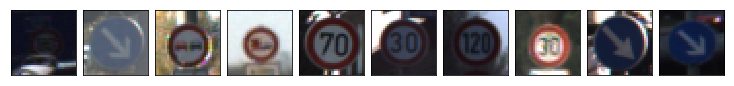

boxed original images


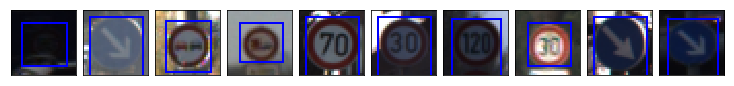

Cropped images


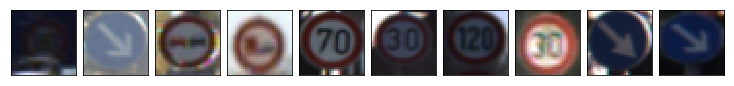

normalized images


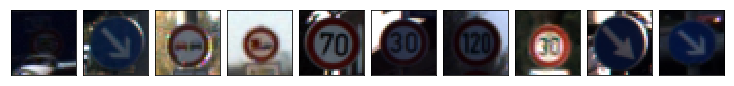

histogram equalized gray scale images


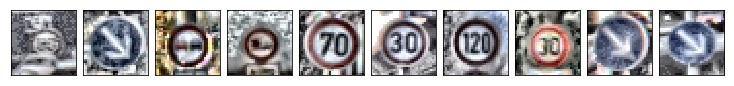

In [4]:
if GENERATE_AUGMENTED_DATA:
    # Pre-process train_dictionary
    X_train_processed = preprocess_data(train_dict, normalize = False, crop = True, gray = True, histEqual = True)

    #Augment pre-processed training data and save in a pickle file
    pickle.dump(augment_data(X_train_processed, y_train), open( './traffic-signs-data/train_augmented.p', "wb" ), protocol= pickle.HIGHEST_PROTOCOL)
    

if USE_AUGMENTED:
    display_samples(X_train)
else:
    display_samples(X_train, coords_train, sizes_train)

In [5]:
display_stats(X_train, y_train, X_valid, y_valid)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32 32]
Number of classes = 43


### Model Architecture

In [6]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten, batch_norm

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def activation(x, func = 'relu', BN = False):
    if BN == True:
        if func == 'relu':
            return batch_norm(tf.nn.relu(x)) 
        elif func == 'elu':
            return batch_norm(tf.nn.elu(x))
        elif func == 'lrelu':
            return batch_norm(tf.nn.leaky_relu(x, alpha = 0.1))
        else:
            assert False, " unsupported activation function used"
    else:
        if func == 'relu':
            return tf.nn.relu(x)
        elif func == 'elu':
            return tf.nn.elu(x)
        elif func == 'lrelu':
            return tf.nn.leaky_relu(x, alpha = 0.1)
        else:
            assert False, " unsupported activation function used"
    

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    ''' Sameer
    return tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID') + b
    '''
    return x

def LeNet(x, BN):    
    
    if GRAY_SCALE:
        n_channels = 1
    else:
        n_channels = 3
        
    BN_flag = BN
    activation_func = 'relu'
       
    # conv1: Input = 32x32X1. Output = 32x32x6.
    # Weights = 5X5X1X6 = 150
    # Biases = 6
    wc1 = tf.get_variable("wc1", shape = [5, 5, n_channels, 6], initializer=tf.contrib.layers.xavier_initializer())
    bc1 = tf.Variable(tf.zeros(6))
    conv1 = conv2d(x, wc1, bc1)
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    maxp1 = maxpool2d(conv1, k=2)
    #Activation. Output = 14x14x6.
    layer1_out = activation(maxp1, func = activation_func, BN = BN_flag)

    
    # conv2: Input = 14x14X6. Output = 10x10x16.
    # Weights = 5x5x6x16 = 2400
    # Biases = 16
    wc2 = tf.get_variable("wc2", shape = [5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer())
    bc2 = tf.Variable(tf.zeros(16))
    conv2 = conv2d(layer1_out, wc2, bc2)
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    maxp2 = maxpool2d(conv2, k=2)
    #Activation. Output = 5x5x16.
    layer2_out = activation(maxp2, func = activation_func, BN = BN_flag)
    
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc3_inp = flatten(layer2_out)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Weights = 400*120 = 48000
    # Biases = 120    
    wfc3 = tf.get_variable("wfc3", shape = [400, 120], initializer=tf.contrib.layers.xavier_initializer())
    bfc3 = tf.Variable(tf.zeros(120))    
    fc3  = tf.add(tf.matmul(fc3_inp,wfc3),bfc3)
    # TODO: Activation.
    layer3_out = activation(fc3, func = activation_func, BN = BN_flag)


    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Weights = 120*84 ~ 10k
    # Biases = 84    
    wfc4 = tf.get_variable("wfc4", shape = [120, 84], initializer=tf.contrib.layers.xavier_initializer())
    bfc4 = tf.Variable(tf.zeros(84))    
    fc4  = tf.add(tf.matmul(layer3_out, wfc4),bfc4)
    # TODO: Activation.
    layer4_out = activation(fc4, func = activation_func, BN = BN_flag)
    

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    # Weights = 84*43 ~ 3.6k
    # Biases = 43
    wfc5 = tf.get_variable("wfc5", shape = [84, 43], initializer=tf.contrib.layers.xavier_initializer())
    bfc5 = tf.Variable(tf.zeros(43))    
    fc5  = tf.add(tf.matmul(layer4_out, wfc5),bfc5)
    logits = fc5
   

    regularizers = tf.nn.l2_loss(wfc3) + tf.nn.l2_loss(wfc4)
    return logits, regularizers



## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline


In [7]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

#************************************************************************************
#                               HYPER-PARAMETERS
#************************************************************************************
if GRAY_SCALE:
    n_channels = 1
else:
    n_channels = 3


#************************************************************************************
#                               INPUT-Variables
#************************************************************************************
x = tf.placeholder(tf.float32, (None, 32, 32, n_channels))
y = tf.placeholder(tf.int32, (None))
# Regularization
keep_prob = tf.placeholder(tf.float32, (None))
ell_2_beta = tf.placeholder(tf.float32, (None))
# Learning rate
learn_rate = tf.placeholder(tf.float32, (None))
# Batch norm
BN = tf.placeholder(tf.bool, (None))





N_CLASSES = 43
one_hot_y = tf.one_hot(y, N_CLASSES)


#************************************************************************************
#                               Choose the network
#************************************************************************************
logits, regularizers = LeNet(x, BN)
saver = tf.train.Saver()
#************************************************************************************

    
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
#loss_operation = tf.reduce_mean(cross_entropy)
loss_without_regularization = tf.reduce_mean(cross_entropy)


loss_operation = tf.reduce_mean(loss_without_regularization + ell_2_beta * regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
training_operation = optimizer.minimize(loss_operation)

prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# Train the Model


In [24]:
X_valid = preprocess_data(valid_dict, normalize = True, crop = False, gray = False, histEqual = True)

(4410, 32, 32, 3)
(4410, 32, 32, 3)
(4410, 32, 32, 3)
(4410, 32, 32, 3)
(4410, 32, 32, 3)


In [8]:
'''
Pre-process data
'''

X_train = preprocess_data(train_dict, normalize = True, crop = False, gray = GRAY_SCALE, histEqual = True)
X_valid = preprocess_data(valid_dict, normalize = True, crop = False, gray = GRAY_SCALE, histEqual = True)
X_test  = preprocess_data(test_dict, normalize = True, crop = False, gray = GRAY_SCALE, histEqual = True)

print(X_train.shape)
if LEARNING_CURVE:
    step_size = np.minimum(2048, X_train.shape[0])
else:
    step_size = X_train.shape[0]

learning_curve_results = learning_curve(X_train, y_train, X_valid, y_valid, step_size)

training_accuracy_vs_m = learning_curve_results['training_accuracy'][:,-1]
training_loss_vs_m = learning_curve_results ['training_loss'][:,-1]
validation_accuracy_vs_m = learning_curve_results['validation_accuracy'][:,-1]
validation_loss_vs_m = learning_curve_results['validation_loss'][:,-1]


(34799, 32, 32, 3)
Training using 34799 training samples and 4410 validation samples

EPOCH 1 ...
Time taken = 18.83, 1.27 
Learning rate = 1.000
Training Accuracy = 0.979
Training Loss = 0.502
Validation Accuracy = 0.895
Validation Loss = 0.739

EPOCH 2 ...
Time taken = 18.90, 1.19 
Learning rate = 1.000
Training Accuracy = 0.936
Training Loss = 0.422
Validation Accuracy = 0.900
Validation Loss = 0.597

EPOCH 3 ...
Time taken = 18.77, 1.19 
Learning rate = 1.000
Training Accuracy = 0.979
Training Loss = 0.248
Validation Accuracy = 0.897
Validation Loss = 0.545

EPOCH 4 ...
Time taken = 19.21, 1.19 
Learning rate = 1.000
Training Accuracy = 0.979
Training Loss = 0.212
Validation Accuracy = 0.939
Validation Loss = 0.396

EPOCH 5 ...
Time taken = 18.98, 1.29 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.170
Validation Accuracy = 0.956
Validation Loss = 0.298

EPOCH 6 ...
Time taken = 18.95, 1.27 
Learning rate = 1.000
Training Accuracy = 0.979
Training Loss = 0.165
V

EPOCH 52 ...
Time taken = 19.43, 1.28 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.059
Validation Accuracy = 0.943
Validation Loss = 0.303

EPOCH 53 ...
Time taken = 19.32, 1.28 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.051
Validation Accuracy = 0.954
Validation Loss = 0.235

EPOCH 54 ...
Time taken = 19.34, 1.28 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.050
Validation Accuracy = 0.960
Validation Loss = 0.208

EPOCH 55 ...
Time taken = 19.43, 1.28 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.058
Validation Accuracy = 0.946
Validation Loss = 0.262

EPOCH 56 ...
Time taken = 19.32, 1.28 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.051
Validation Accuracy = 0.952
Validation Loss = 0.257

EPOCH 57 ...
Time taken = 19.29, 1.28 
Learning rate = 1.000
Training Accuracy = 1.000
Training Loss = 0.060
Validation Accuracy = 0.952
Validation Loss = 0.258

EPOCH 58 ...
Time taken = 19

In [9]:
with tf.Session() as sess:
    saver.restore(sess,  './OptimizedModel')
    test_results_dict   = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_results_dict['accuracy']))
    print("Test Loss = {:.3f}".format(test_results_dict['loss']))

INFO:tensorflow:Restoring parameters from ./OptimizedModel
Test Accuracy = 0.944
Test Loss = 0.356


In [10]:
training_accuracy_vs_iter = learning_curve_results['training_accuracy'][0,:]
training_loss_vs_iter = learning_curve_results['training_loss'][0,:]
validation_accuracy_vs_iter = learning_curve_results['validation_accuracy'][0,:]
validation_loss_vs_iter = learning_curve_results['validation_loss'][0,:]

In [11]:
print(learning_curve_results['training_accuracy'].shape[0])

1


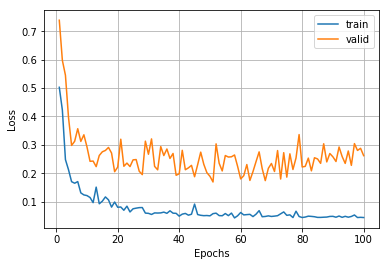

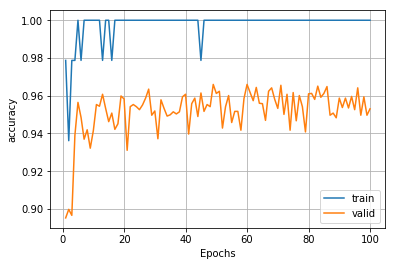

In [12]:
%matplotlib inline
num = 0
plt.figure()
for i in range(learning_curve_results['training_accuracy'].shape[0]):
    if i==num:
        training_loss_vs_iter = learning_curve_results['training_loss'][i,:]
        validation_loss_vs_iter = learning_curve_results['validation_loss'][i,:]    
        plt.plot(np.arange(1, len(training_loss_vs_iter)+1), training_loss_vs_iter, label = 'train')
        plt.plot(np.arange(1, len(validation_loss_vs_iter)+1), validation_loss_vs_iter, label = 'valid')

plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

%matplotlib inline
plt.figure()
for i in range(learning_curve_results['training_accuracy'].shape[0]):
    if i==num:
        training_accuracy_vs_iter = learning_curve_results['training_accuracy'][i,:]
        validation_accuracy_vs_iter = learning_curve_results['validation_accuracy'][i,:]    
        plt.plot(np.arange(1, len(training_accuracy_vs_iter)+1), training_accuracy_vs_iter, label = 'train')
        plt.plot(np.arange(1, len(validation_accuracy_vs_iter)+1), validation_accuracy_vs_iter, label = 'valid')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

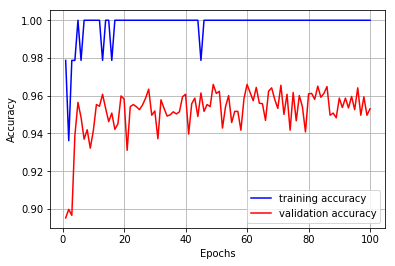

In [13]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(1, len(training_accuracy_vs_iter)+1), training_accuracy_vs_iter, 'b', label = 'training accuracy')
plt.plot(np.arange(1, len(validation_accuracy_vs_iter)+1), validation_accuracy_vs_iter, 'r', label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
training_results_dict   = evaluate(X_test, y_test)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, os.path
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
import cv2

X_test_web = []
y_test_web = []
path = "./traffic-signs-data/webimages/"
valid_images = [".jpg",".gif",".png",".tga"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    print('read image = ' + f)
    image = mpimage.imread(path+f)
    dim = (32, 32)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    print(image.shape)
    X_test_web.append(image)
    plt.imshow(image)
    plt.show()
print(np.array(X_test_web).shape)

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
X_test_web = np.array(X_test_web)
X_test_web = RGB_2_gray_dataset(X_test_web)
X_test_web = normalize_dataset(X_test_web)
y_test_web = np.array([23, 23, 28, 1, 9, 28, 23, 28])

### Analyze Performance

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    X_data = X_test_web
    y_data = y_test_web
    dataset_accuracy = evaluate(X_data, y_data)
    print("data set accuracy = {}".format(dataset_accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
dataset_prediction = []
top_k_predictions = []
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    X_data = X_test_web
    k = 5
    top_k_values, top_k_ind = tf.nn.top_k(tf.nn.softmax(sess.run(logits, feed_dict={x: X_data, keep_prob: 1})), k)
    dataset_prediction.append(top_k_ind[1])
    top_k_predictions.append(top_k_ind)
    print(sess.run(top_k_predictions))

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

In [ ]:
[23, 23, 28, 1, 9, 28, 23, 28])

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")